In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, AgglomerativeClustering, HDBSCAN
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import umap

# Utility Functions
from utils import *
from plotmat import *
from tqdm import tqdm
from functools import partial
from multiprocessing import Pool, cpu_count
import itertools

%load_ext autoreload
%autoreload 2

# ECE 219 Project 2: Data Representations and Clustering

## Part 1 - Clustering on Text Data

In [18]:
# Fetch "20 Newsgroup Dataset" & convert to Pandas dataframe
subclasses = [
    'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', # Class 1
    'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey' # Class 2
]
ng_dataset = fetch_20newsgroups(categories=subclasses, remove=('headers', 'footers'))
ng_df = pd.DataFrame({
    'text': ng_dataset.data,
    'target': ng_dataset.target
})
ng_df['target_verbose'] = ng_df['target'].map({i:n for i, n in enumerate(ng_dataset.target_names)})
ng_df['class'] = ng_df['target'].apply(lambda x: 0 if x <= 3 else 1) # Relabel 'comp' class as 0 and 'rec' class as 1

print(f'Dimensions: {ng_df.shape}')
display(ng_df.head())
display(ng_df['target_verbose'].value_counts())

Dimensions: (4732, 4)


,text,target,target_verbose,class
0,"In article <mssC5KCru.5Ip@netcom.com>, mss@net...",6,rec.sport.baseball,1
1,"In article <1993Apr19.213015@IASTATE.EDU>, njd...",7,rec.sport.hockey,1
2,In <C5Dq2n.5uB@news.cso.uiuc.edu> mwbg9715@uxa...,4,rec.autos,1
3,INABU@ibm.rz.tu-clausthal.de (Arnd Burghardt) ...,2,comp.sys.ibm.pc.hardware,0
4,">> The RISC means ""reduced instruction set co...",1,comp.os.ms-windows.misc,0


target_verbose
rec.sport.hockey            600
rec.motorcycles             598
rec.sport.baseball          597
rec.autos                   594
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    590
comp.graphics               584
comp.sys.mac.hardware       578
Name: count, dtype: int64

In [19]:
# List out the targets and their verbose labels
ng_df[['target', 'target_verbose']].drop_duplicates().sort_values('target')

,target,target_verbose
6,0,comp.graphics
4,1,comp.os.ms-windows.misc
3,2,comp.sys.ibm.pc.hardware
5,3,comp.sys.mac.hardware
2,4,rec.autos
8,5,rec.motorcycles
0,6,rec.sport.baseball
1,7,rec.sport.hockey


### Clustering with Sparse Text Representations

In [20]:
# Generating TF-IDF representations
pipe = Pipeline([
    # Step 1: Data Cleaning
    ('doc_preprocess', DocumentPreprocessingTransformer()),
    # Lemmatization not required for this question
    # ('lemmatization', LemmatizationPOSTransfomer()),
    # Step 2: Count Vectorization + Stop Word Removal
    ('cvector', CountVectorizer(stop_words='english', min_df=3)),
    # Step 3: TF-IDF Transformation
    ('tfidf', TfidfTransformer())
])

ng_tfidf = pipe.fit_transform(ng_df['text'])
ng_tfidf.shape

(4732, 12952)

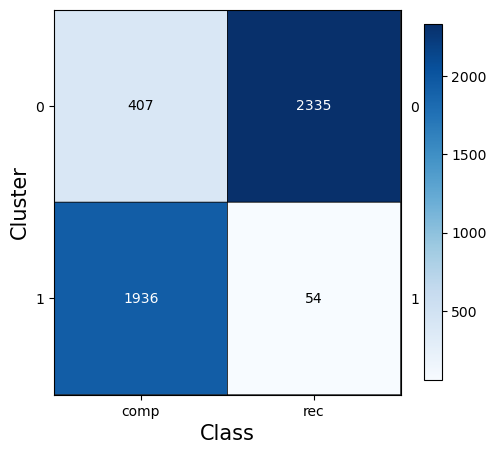

In [21]:
# Initialize and run KMeans Clustering
kmeans = KMeans(
    n_clusters=2,
    random_state=0,
    max_iter = 5000,
    n_init = 50
)

kmeans = kmeans.fit(ng_tfidf)

# Contingency Table + Visualization
contingency_tbl = pd.crosstab(ng_df['class'], pd.Series(kmeans.labels_, name='cluster'))
plot_mat(
    mat=contingency_tbl.T.to_numpy(), 
    size=(5,5),
    xticklabels=['comp', 'rec'],
    xlabel='Class',
    ylabel='Cluster',
)

In [22]:
# Evaluation: Homogeneity, Completeness, V-measure, Adjusted Rand Index, Adjusted mutual information score
evaluate_cluster_model(ng_df['class'], kmeans.labels_)

,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information Score,Rand Score
0,0.573255,0.583898,0.578528,0.648203,0.578463,0.824101


### Clustering with Dense Text Representations

#### Generate Dense Representations for Better K-Means Clustering

100%|██████████| 1000/1000 [00:00<00:00, 28796.75it/s]


Text(0.5, 1.0, "Percentage of Variance Retained for Top 'r' Principle Components")

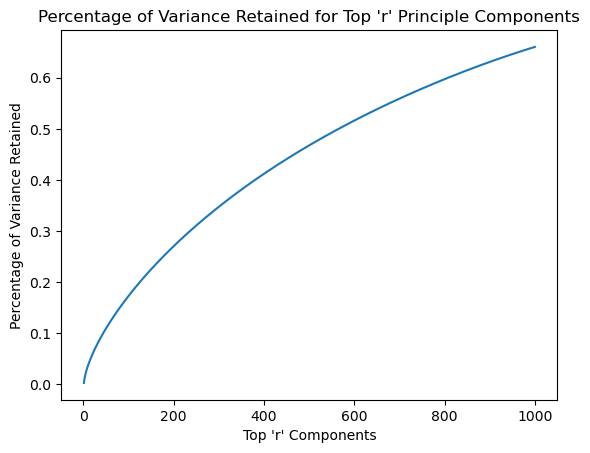

In [23]:
# Truncated SVD - Percent of Variance Retained vs Top r Components
comp_vs_var = []
svd_reduction = TruncatedSVD(n_components=1000).fit(ng_tfidf)
var_ratios = svd_reduction.explained_variance_ratio_
for r in tqdm(range(1, 1001)):
    comp_vs_var += [(r, sum(var_ratios[:r]))]
comp_vs_var = np.array(comp_vs_var) # Convert to numpy array for easier indexing

# Plot relationship
plt.plot(comp_vs_var[:, 0], comp_vs_var[:, 1])
plt.xlabel("Top 'r' Components")
plt.ylabel("Percentage of Variance Retained")
plt.title("Percentage of Variance Retained for Top 'r' Principle Components")

In [25]:
# Assess Clustering Metrics Across Different Top R Components for both Truncated SVD and NMF
# NOTE: Be careful when running this chunk! NMF takes forever for r=300. 
dim_reduction_results = [] # (# components, svd_results, nmf_results)
components_to_test = list(range(1, 11)) + [20, 50, 100, 300]
svd_reduction_transforms = svd_reduction.transform(ng_tfidf) # Can just take the first r components directly
for i in tqdm(components_to_test):
    # SVD
    kmeans_svd = KMeans(n_clusters=2, random_state=0, max_iter=5000, n_init=50)
    kmean_svd_results = kmeans_svd.fit_predict(svd_reduction_transforms[:, :i])

    # NMF
    nmf_reduction = NMF(n_components=i).fit_transform(ng_tfidf)
    kmeans_nmf = KMeans(n_clusters=2, random_state=0, max_iter=5000, n_init=50)
    kmean_nmf_results = kmeans_nmf.fit_predict(nmf_reduction)

    dim_reduction_results += [(i, kmean_svd_results, kmean_nmf_results)]
    

 93%|█████████▎| 13/14 [01:26<00:16, 16.86s/it]/opt/anaconda3/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
100%|██████████| 14/14 [09:08<00:00, 39.21s/it] 


In [26]:
# Get metrics for both SVD and NMF reduction methods
svd_metrics = pd.DataFrame(columns=['Components', 'Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand Index', 'Adjusted Mutual Information Score'])
nmf_metrics = svd_metrics.copy()
for n_comp, svd_labels, nmf_labels in dim_reduction_results:
    svd_metric_vals = evaluate_cluster_model(ng_df['class'], svd_labels).drop(columns=['Rand Score'])
    svd_metric_vals['Components'] = n_comp
    svd_metrics = pd.concat([svd_metrics, svd_metric_vals])

    nmf_metric_vals = evaluate_cluster_model(ng_df['class'], nmf_labels).drop(columns=['Rand Score'])
    nmf_metric_vals['Components'] = n_comp
    nmf_metrics = pd.concat([nmf_metrics, nmf_metric_vals])

svd_metrics['Components'] = svd_metrics['Components'].astype(int)
nmf_metrics['Components'] = nmf_metrics['Components'].astype(int)

/var/folders/bc/1xf6kfn55rqfytwcbxjxqdr00000gn/T/ipykernel_49122/200608924.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  svd_metrics = pd.concat([svd_metrics, svd_metric_vals])
/var/folders/bc/1xf6kfn55rqfytwcbxjxqdr00000gn/T/ipykernel_49122/200608924.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  nmf_metrics = pd.concat([nmf_metrics, nmf_metric_vals])


<Axes: xlabel='Components'>

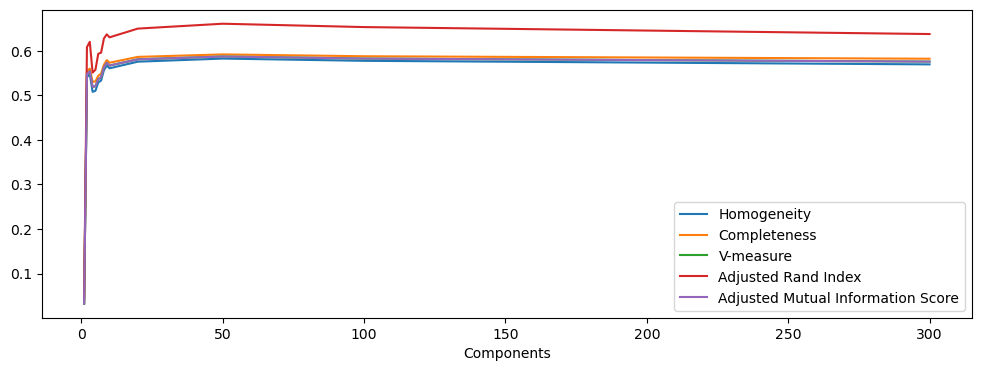

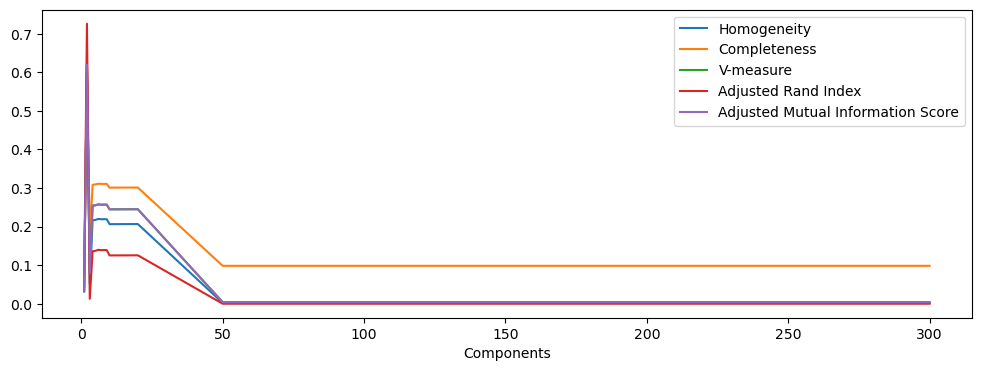

In [28]:
svd_metrics.plot(x='Components', figsize=(12, 4))
nmf_metrics.plot(x='Components', figsize=(12, 4))


| Dimensionality Reduction Method | Optimal Number of Components |
|---------------------------------|------------------------------|
| SVD | 50 |
| NMF | 2 |

#### Visualizing Clusters

In [153]:
svd_rep = TruncatedSVD(n_components=50).fit_transform(ng_tfidf)
nmf_rep = NMF(n_components=2).fit_transform(ng_tfidf)

kmeans_svd_labels = KMeans(n_clusters=2, random_state=0, max_iter=5000, n_init=50).fit_predict(svd_rep)
kmeans_nmf_labels = KMeans(n_clusters=2, random_state=0, max_iter=5000, n_init=50).fit_predict(nmf_rep)

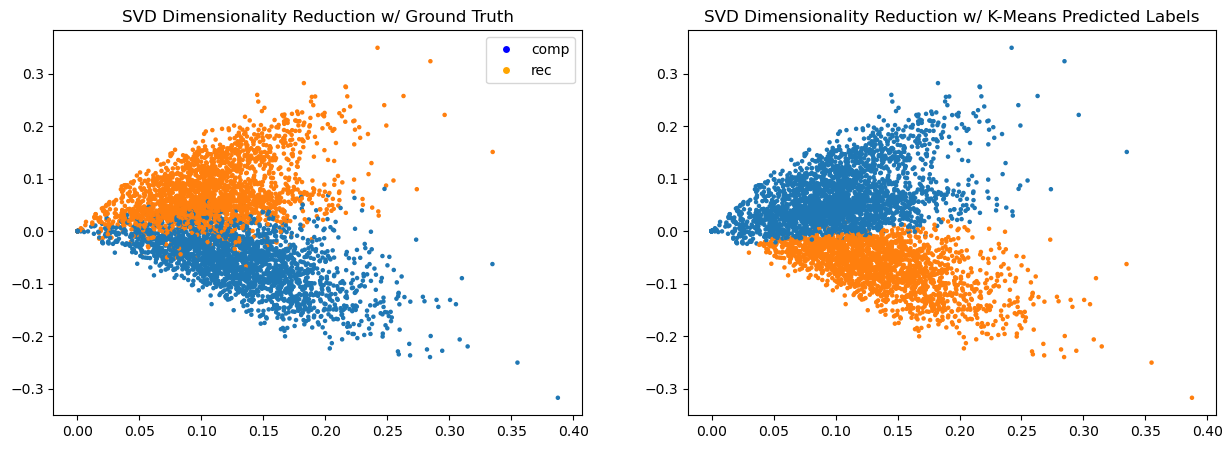

In [194]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Create custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='comp', markerfacecolor='blue'),
    Line2D([0], [0], marker='o', color='w', label='rec', markerfacecolor='orange'),
]

# Plot UMAP Projection for GLoVE Embedding
ax1.scatter(
    svd_rep[:, 0], 
    svd_rep[:, 1], 
    c=[sns.color_palette()[x] for x in ng_df['class']],
    s=5
)
ax1.set_title('SVD Dimensionality Reduction w/ Ground Truth', fontsize=12)
ax1.legend(handles=legend_elements)

# Plot UMAP Projection for Random Vectors
ax2.scatter(
    svd_rep[:, 0], 
    svd_rep[:, 1], 
    c=[sns.color_palette()[x] for x in kmeans_svd_labels],
    s=5
)
ax2.set_title('SVD Dimensionality Reduction w/ K-Means Predicted Labels', fontsize=12)

plt.show()

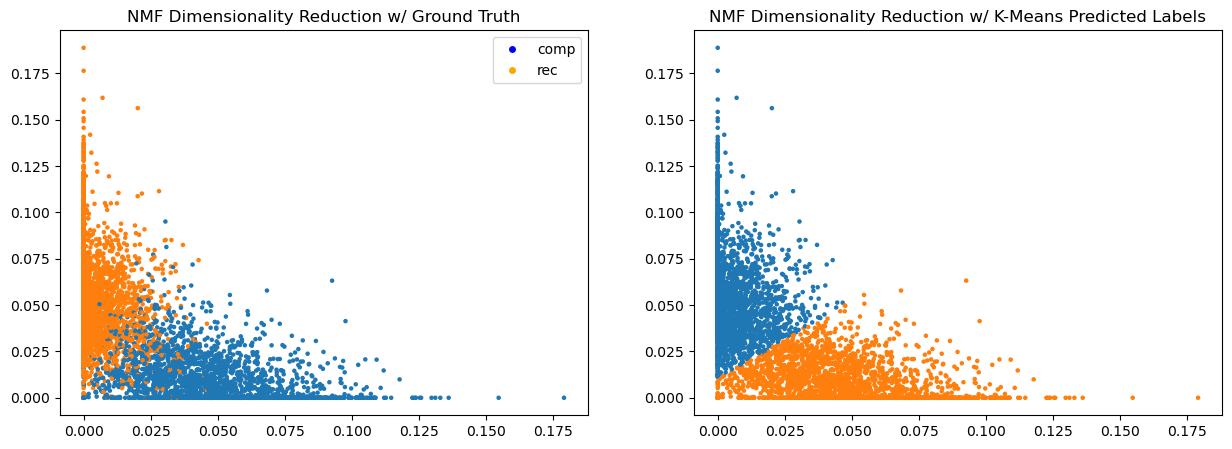

In [195]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Create custom legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='comp', markerfacecolor='blue'),
    Line2D([0], [0], marker='o', color='w', label='rec', markerfacecolor='orange'),
]

# Plot UMAP Projection for GLoVE Embedding
ax1.scatter(
    nmf_rep[:, 0], 
    nmf_rep[:, 1], 
    c=[sns.color_palette()[x] for x in ng_df['class']],
    s=5
)
ax1.set_title('NMF Dimensionality Reduction w/ Ground Truth', fontsize=12)
ax1.legend(handles=legend_elements)

# Plot UMAP Projection for Random Vectors
ax2.scatter(
    nmf_rep[:, 0], 
    nmf_rep[:, 1], 
    c=[sns.color_palette()[x] for x in kmeans_nmf_labels],
    s=5
)
ax2.set_title('NMF Dimensionality Reduction w/ K-Means Predicted Labels', fontsize=12)

plt.show()

#### Clustering of the Entire 20 Classes

In [5]:
# Load in 20Newsgroups dataset again, but with all labels
ng_dataset_full = fetch_20newsgroups(remove=('headers', 'footers'))
ng_full_df = pd.DataFrame({
    'text': ng_dataset_full.data,
    'class': ng_dataset_full.target
})
ng_full_df['class_verbose'] = ng_full_df['class'].map({i:n for i, n in enumerate(ng_dataset_full.target_names)})

print(f'Dimensions: {ng_full_df.shape}')
display(ng_full_df.head())
display(ng_full_df['class_verbose'].value_counts())

Dimensions: (11314, 3)


,text,class,class_verbose
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,Robert J.C. Kyanko (rob@rjck.UUCP) wrote:\n> a...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space


class_verbose
rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
comp.windows.x              593
sci.space                   593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: count, dtype: int64

In [6]:
# Construct TF-IDF Matrix
ng_full_tfidf = pipe.fit_transform(ng_full_df['text'])
ng_full_tfidf.shape

(11314, 28497)

100%|██████████| 13/13 [04:49<00:00, 22.24s/it]
/var/folders/bc/1xf6kfn55rqfytwcbxjxqdr00000gn/T/ipykernel_49122/2713759726.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  svd_metrics = pd.concat([svd_metrics, svd_metric_vals])
/var/folders/bc/1xf6kfn55rqfytwcbxjxqdr00000gn/T/ipykernel_49122/2713759726.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  nmf_metrics = pd.concat([nmf_metrics, nmf_metric_vals])


<Axes: xlabel='Components'>

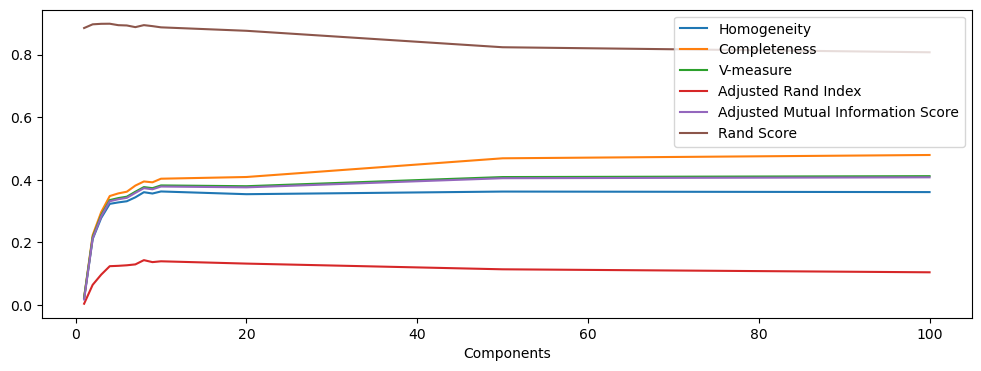

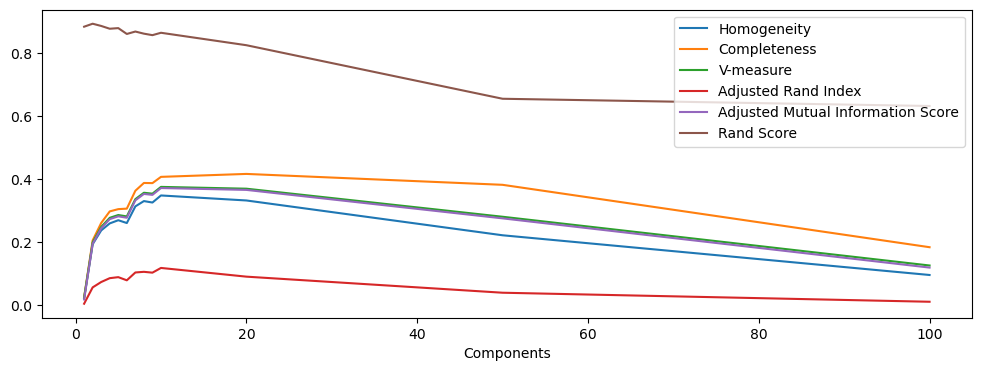

In [8]:
# Rerunning n_component Optimziation Experiment with Full Dataset
dim_reduction_results = [] # (# components, svd_results, nmf_results)
components_to_test = list(range(1, 11)) + [20, 50, 100] # Removed 300 since it takes too long
svd_reduction_transforms = TruncatedSVD(n_components=1000).fit_transform(ng_full_tfidf) # Can just take the first r components directly
for i in tqdm(components_to_test):
    # SVD
    kmeans_svd = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50)
    kmean_svd_results = kmeans_svd.fit_predict(svd_reduction_transforms[:, :i])

    # NMF
    nmf_reduction = NMF(n_components=i).fit_transform(ng_full_tfidf)
    kmeans_nmf = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50)
    kmean_nmf_results = kmeans_nmf.fit_predict(nmf_reduction)

    dim_reduction_results += [(i, kmean_svd_results, kmean_nmf_results)]

svd_metrics = pd.DataFrame(columns=['Components', 'Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand Index', 'Adjusted Mutual Information Score'])
nmf_metrics = svd_metrics.copy()
for n_comp, svd_labels, nmf_labels in dim_reduction_results:
    svd_metric_vals = evaluate_cluster_model(ng_full_df['class'], svd_labels)
    svd_metric_vals['Components'] = n_comp
    svd_metrics = pd.concat([svd_metrics, svd_metric_vals])

    nmf_metric_vals = evaluate_cluster_model(ng_full_df['class'], nmf_labels)
    nmf_metric_vals['Components'] = n_comp
    nmf_metrics = pd.concat([nmf_metrics, nmf_metric_vals])

svd_metrics['Components'] = svd_metrics['Components'].astype(int)
nmf_metrics['Components'] = nmf_metrics['Components'].astype(int)

svd_metrics.plot(x='Components', figsize=(12, 4))
nmf_metrics.plot(x='Components', figsize=(12, 4))

In [13]:
display(svd_metrics[svd_metrics['Homogeneity'] == svd_metrics['Homogeneity'].max()])
display(nmf_metrics[nmf_metrics['Homogeneity'] == nmf_metrics['Homogeneity'].max()])

,Components,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information Score,Rand Score
0,10,0.362743,0.403495,0.382035,0.139555,0.378499,0.887305


,Components,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information Score,Rand Score
0,10,0.348312,0.407455,0.37557,0.117748,0.3719,0.865775


In [14]:
# Dimensionality Reduction w/ SVD and NMF - use same number of components as before
svd_rep = TruncatedSVD(n_components=10).fit_transform(ng_full_tfidf)
nmf_rep = NMF(n_components=10).fit_transform(ng_full_tfidf)

kmeans_svd_labels = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit_predict(svd_rep)
kmeans_nmf_labels = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit_predict(nmf_rep)


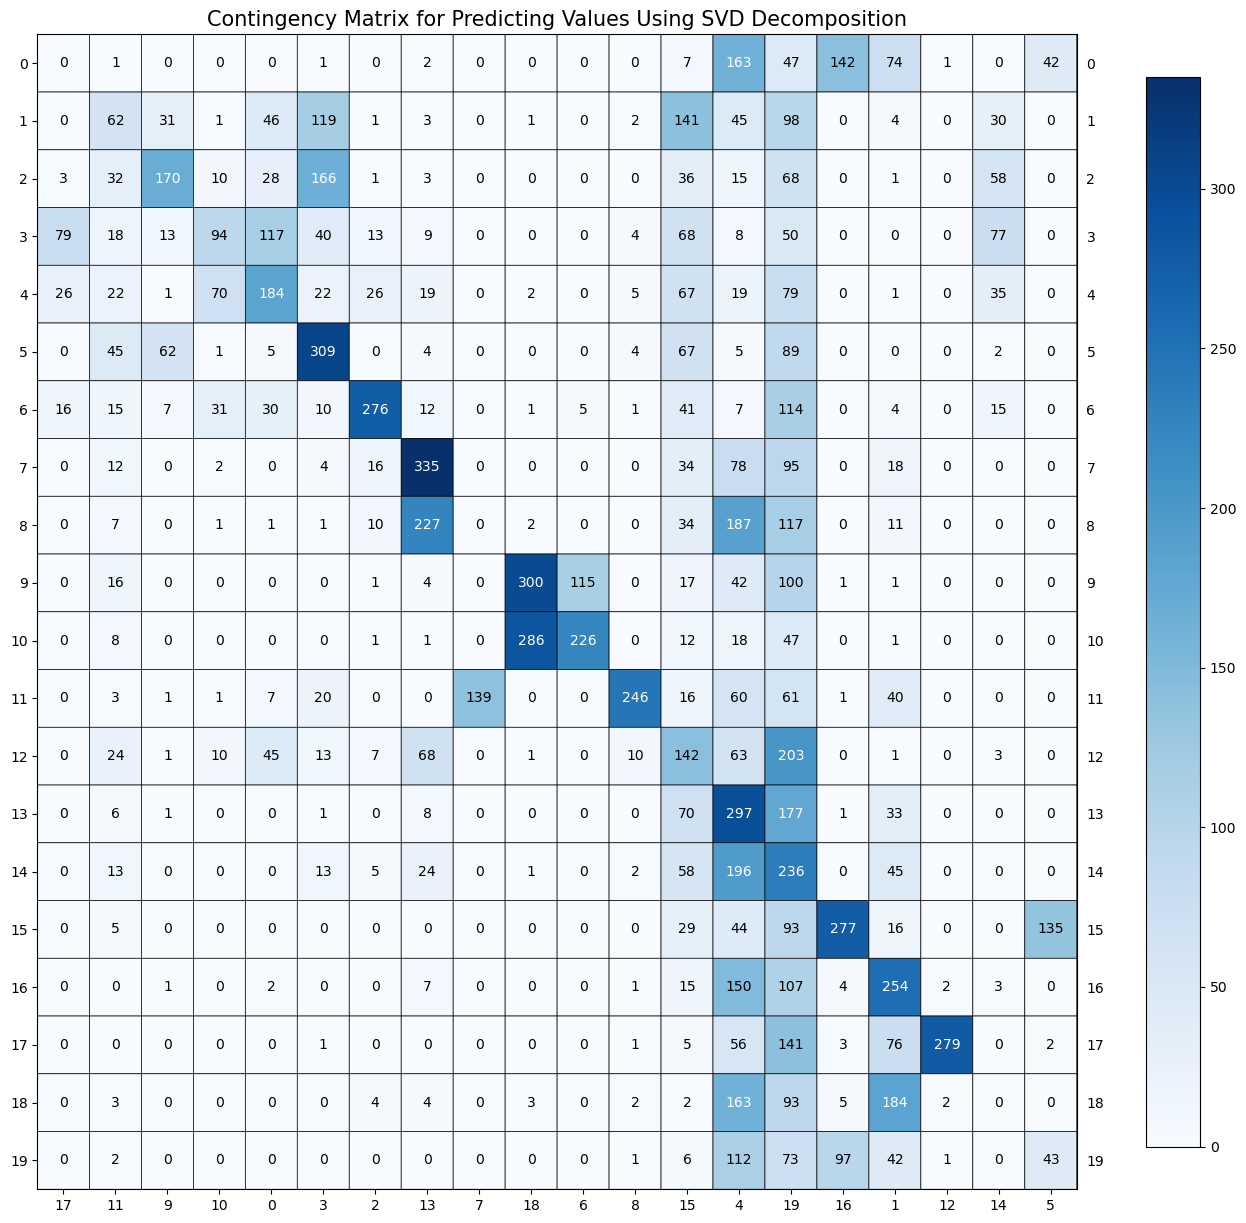

,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information Score,Rand Score
0,0.364356,0.405051,0.383628,0.141249,0.380102,0.887913


In [15]:
# Contingency Matrix for SVD
cm = confusion_matrix(ng_full_df['class'], kmeans_svd_labels)
rows, cols = linear_sum_assignment(cm, maximize=True)

plot_mat(
    cm[rows[:, np.newaxis], cols], 
    xticklabels=cols, 
    yticklabels=rows, 
    size=(15,15),
    title='Contingency Matrix for Predicting Values Using SVD Decomposition'
)

evaluate_cluster_model(ng_full_df['class'], kmeans_svd_labels)

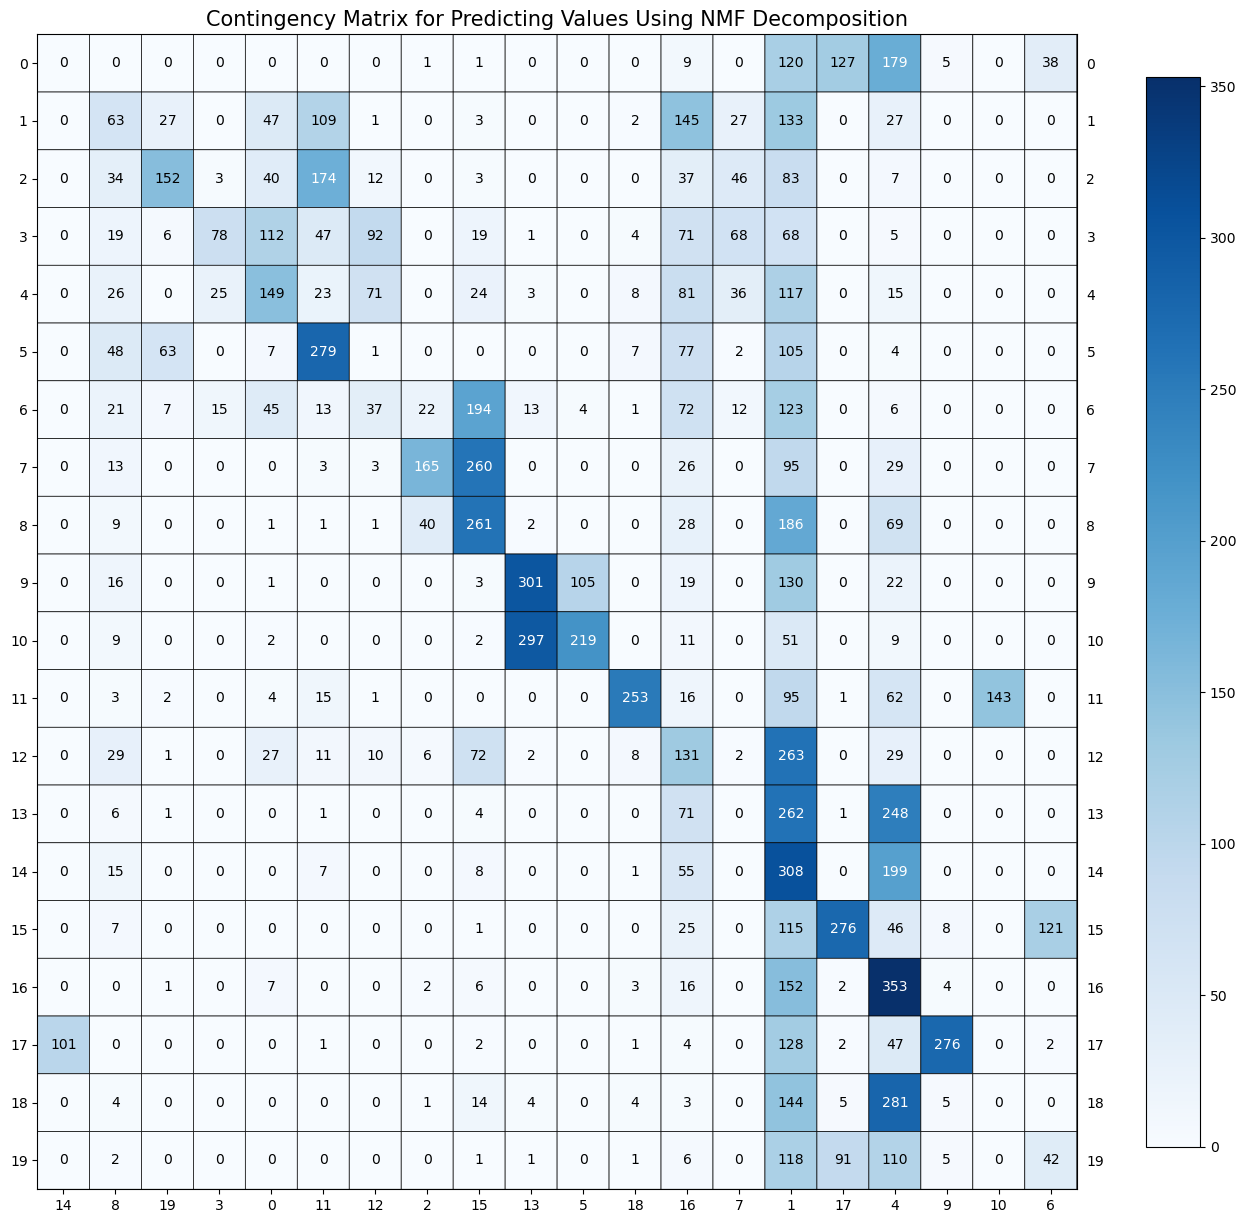

,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information Score,Rand Score
0,0.349006,0.407819,0.376128,0.1179,0.372464,0.866029


In [16]:
# Contingency Matrix for NMF
cm = confusion_matrix(ng_full_df['class'], kmeans_nmf_labels)
rows, cols = linear_sum_assignment(cm, maximize=True)

plot_mat(
    cm[rows[:, np.newaxis], cols], 
    xticklabels=cols, 
    yticklabels=rows, 
    size=(15,15),
    title='Contingency Matrix for Predicting Values Using NMF Decomposition'
)

evaluate_cluster_model(ng_full_df['class'], kmeans_nmf_labels)

### UMAP

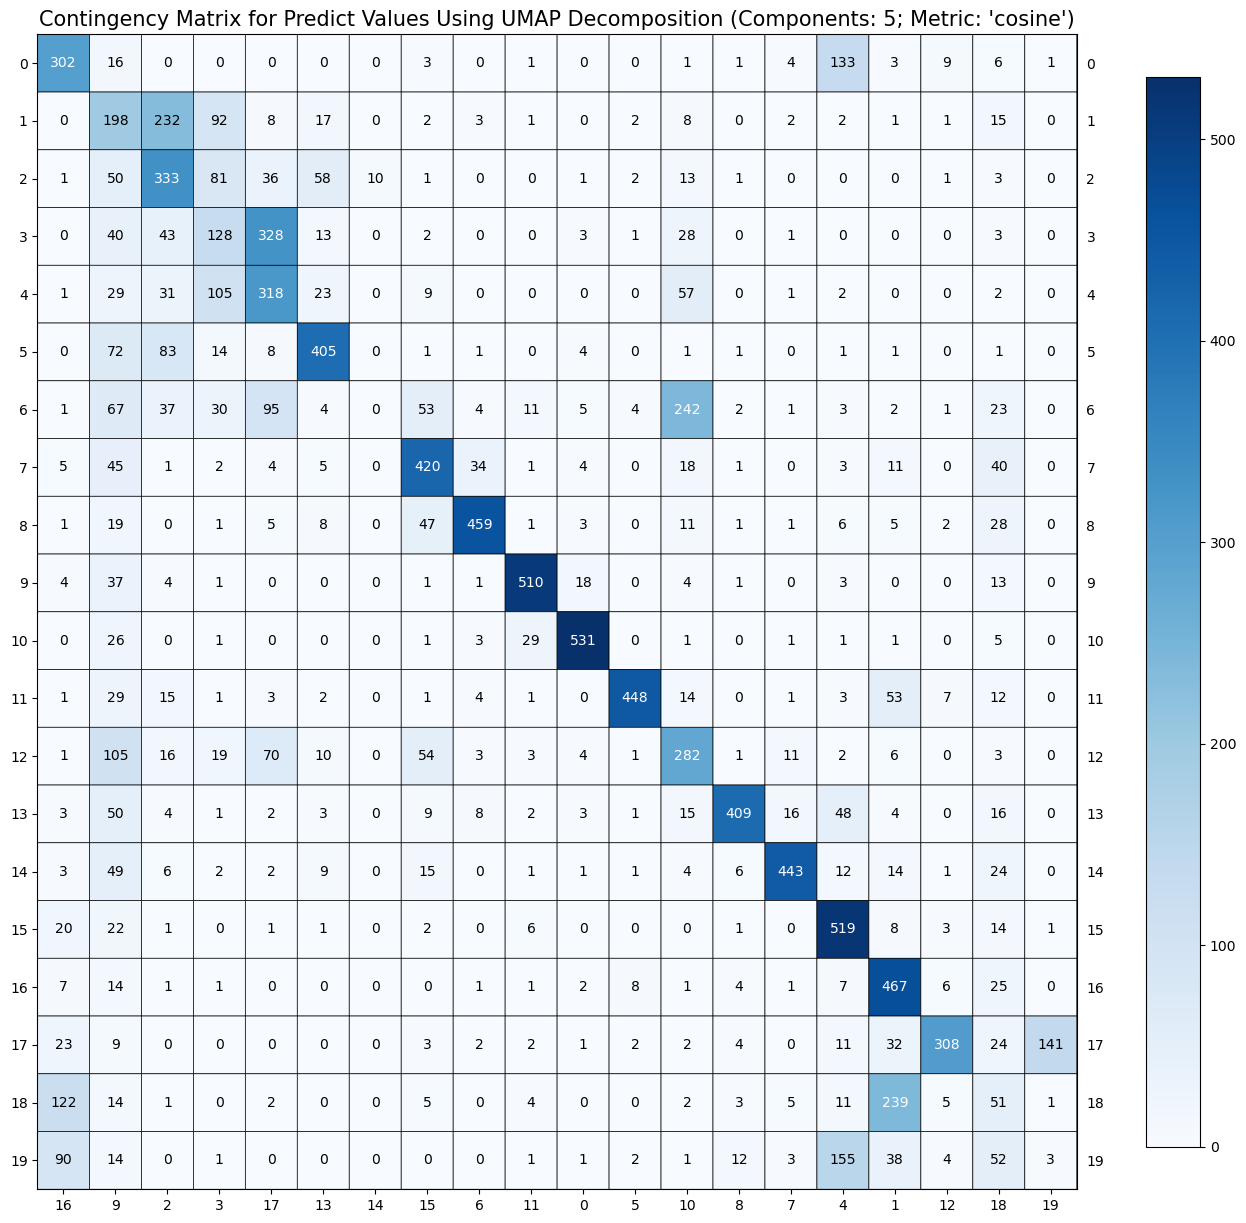

/var/folders/bc/1xf6kfn55rqfytwcbxjxqdr00000gn/T/ipykernel_49122/349101980.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat([eval_df, eval_metrics])


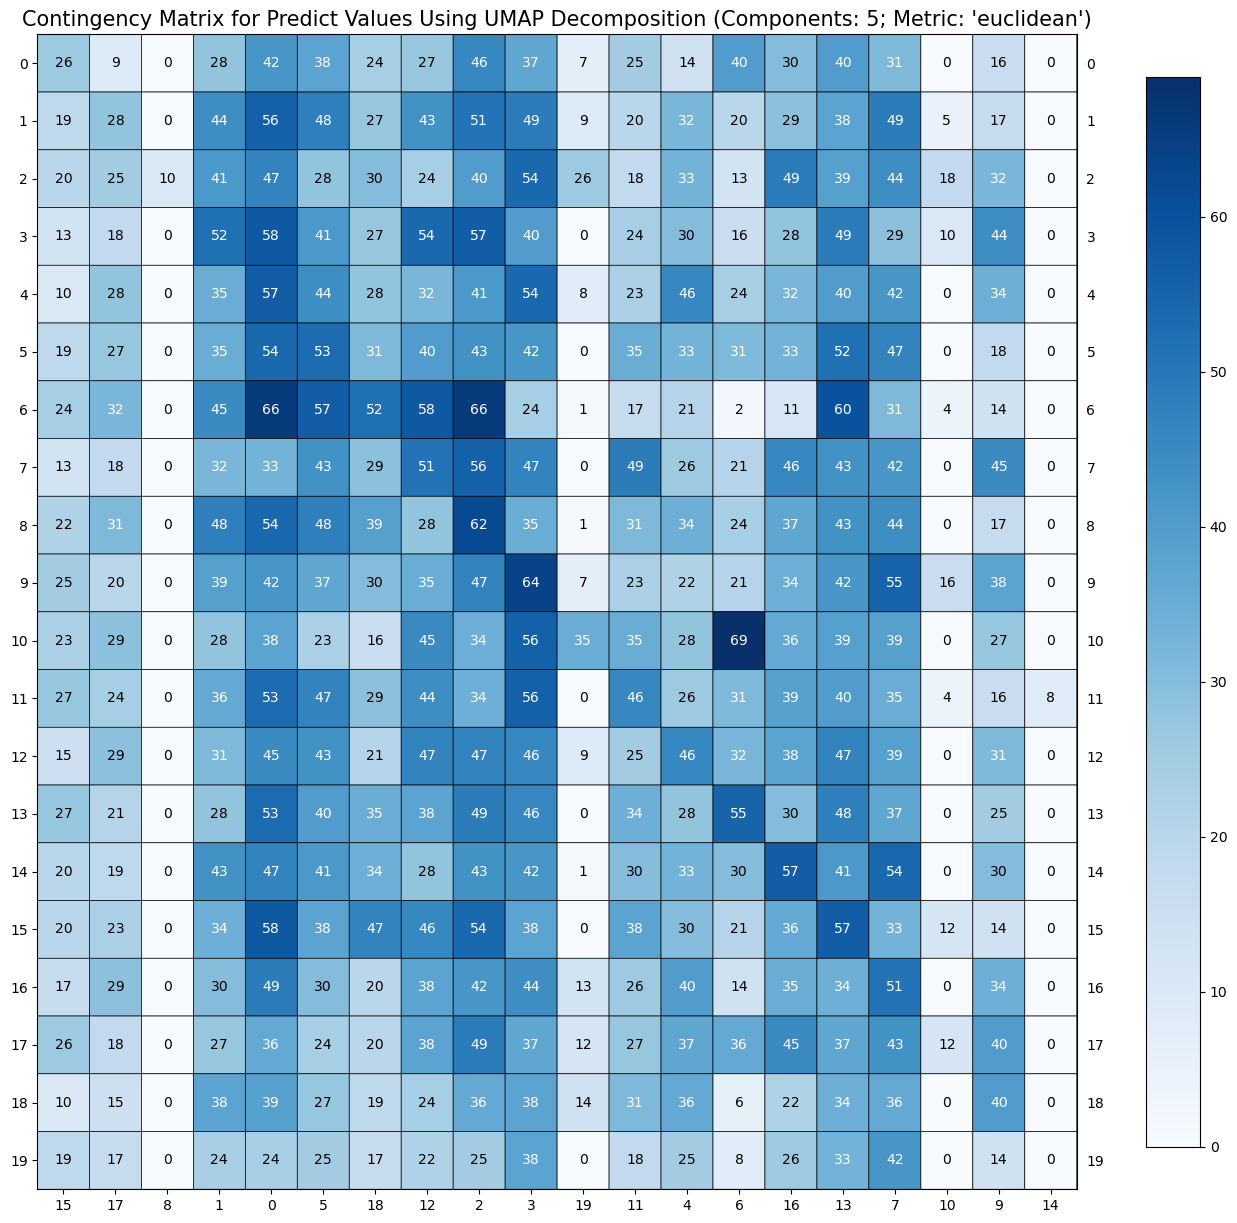

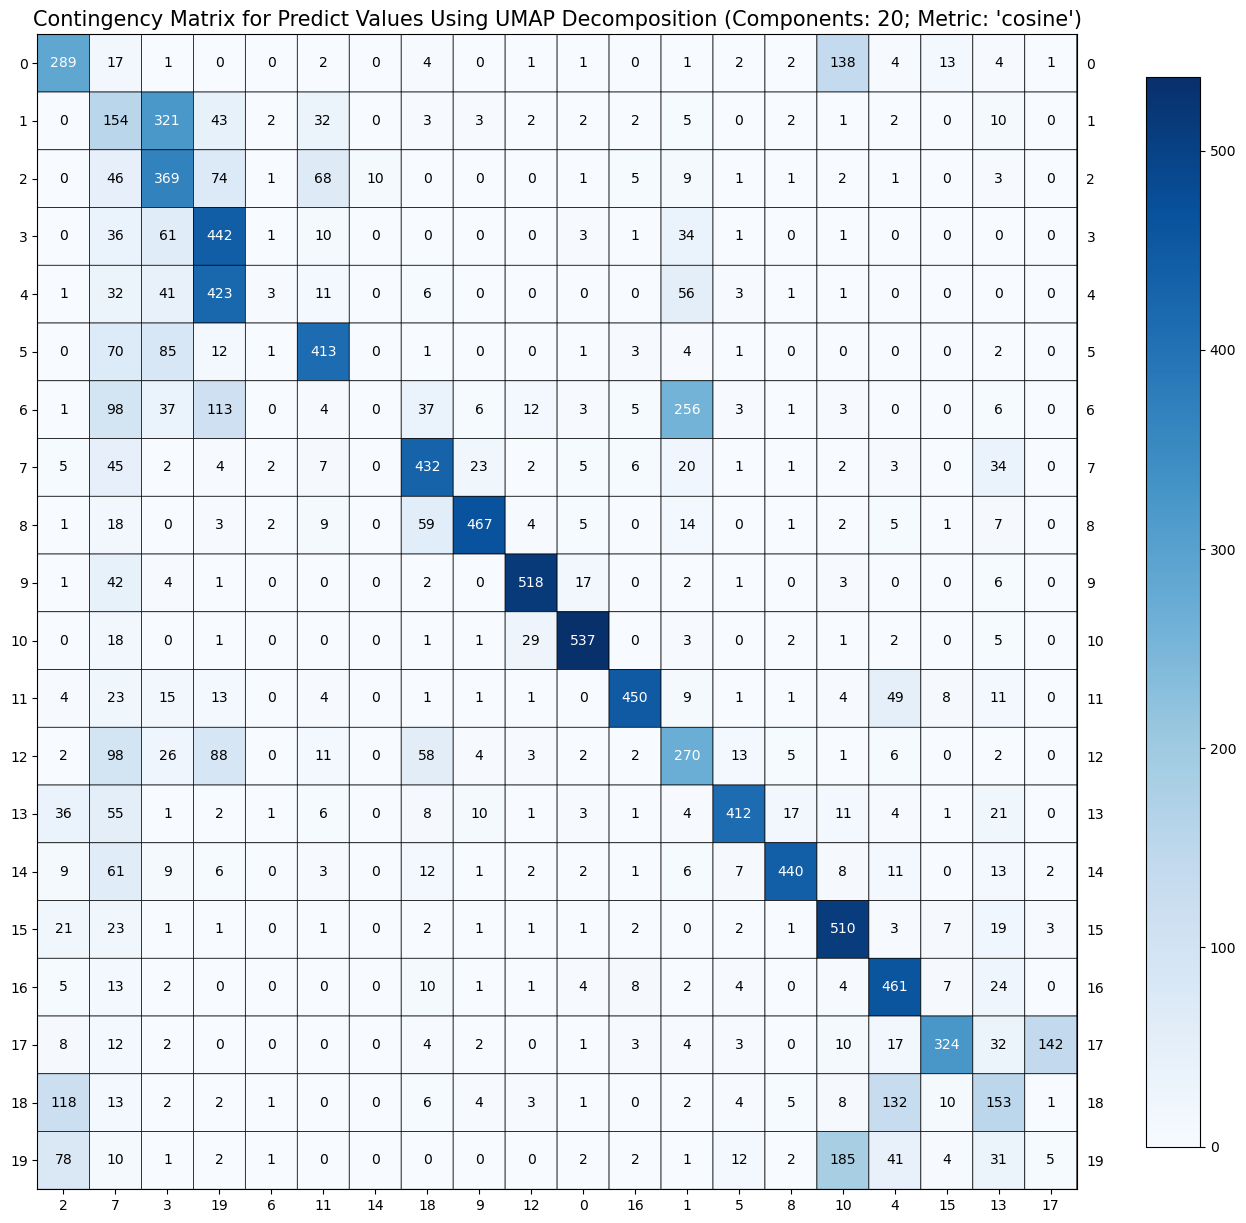

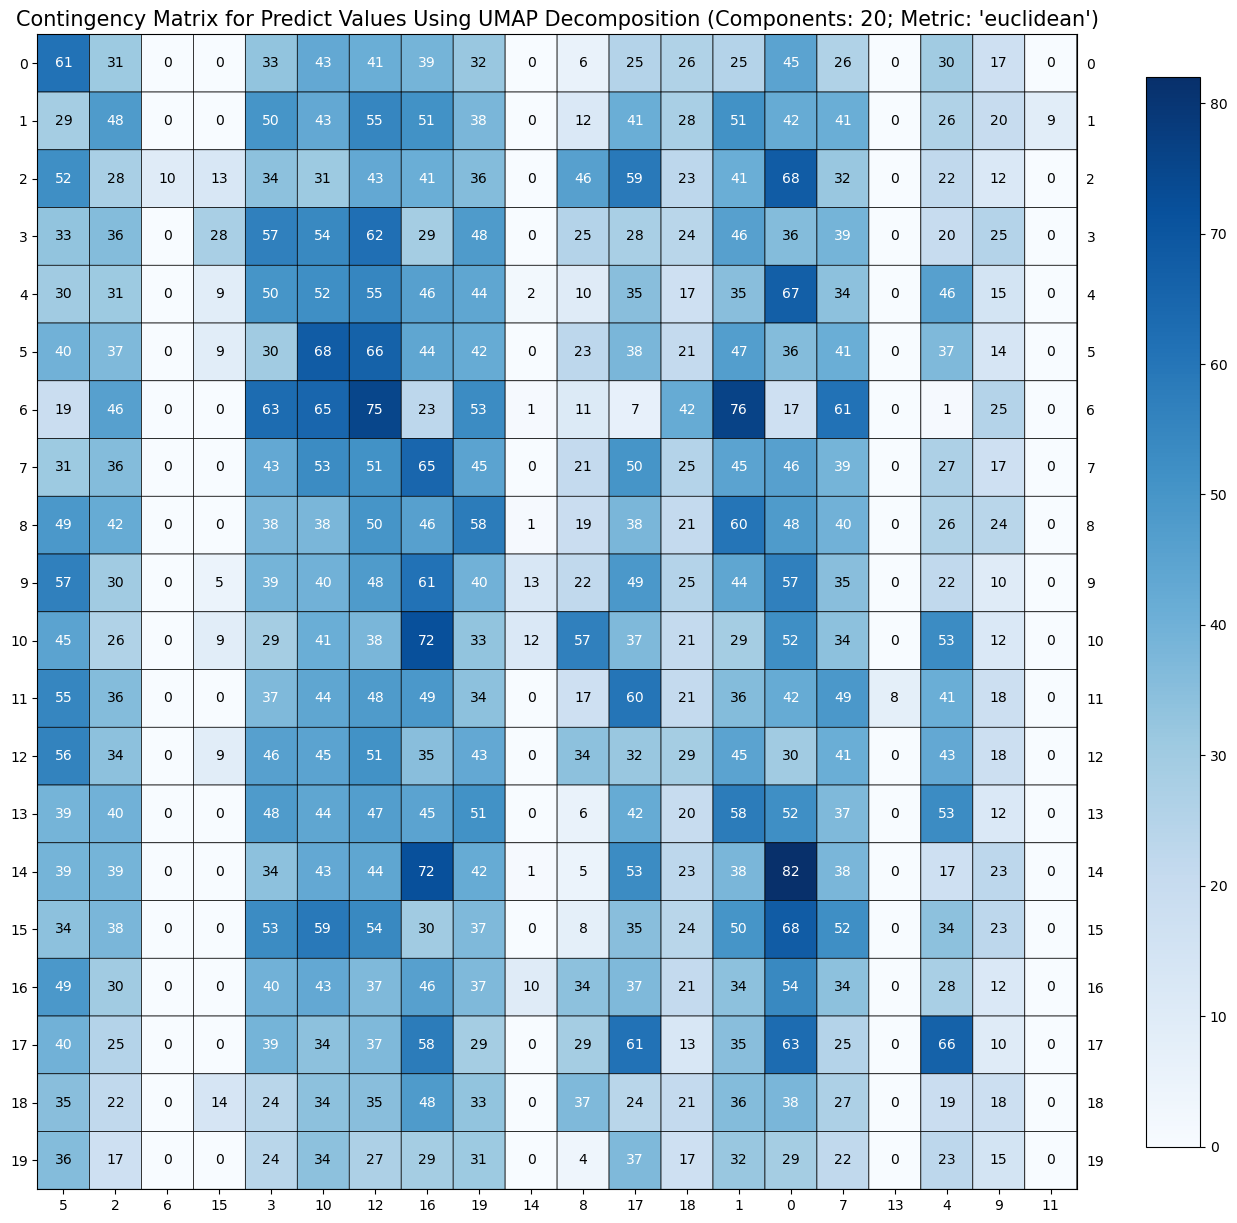

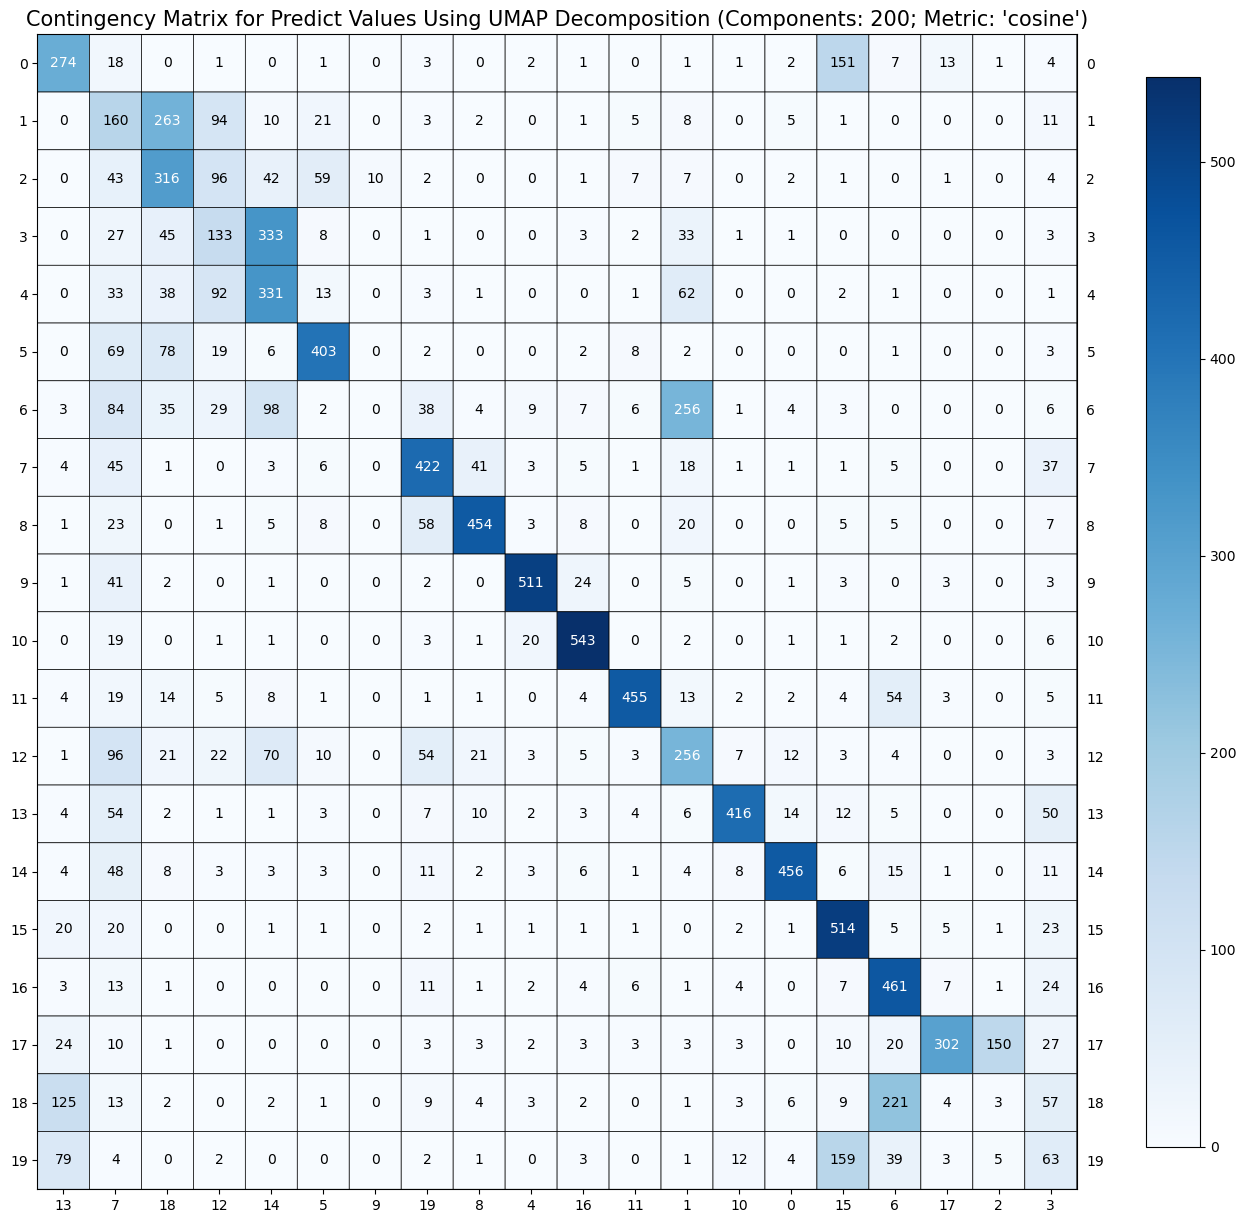

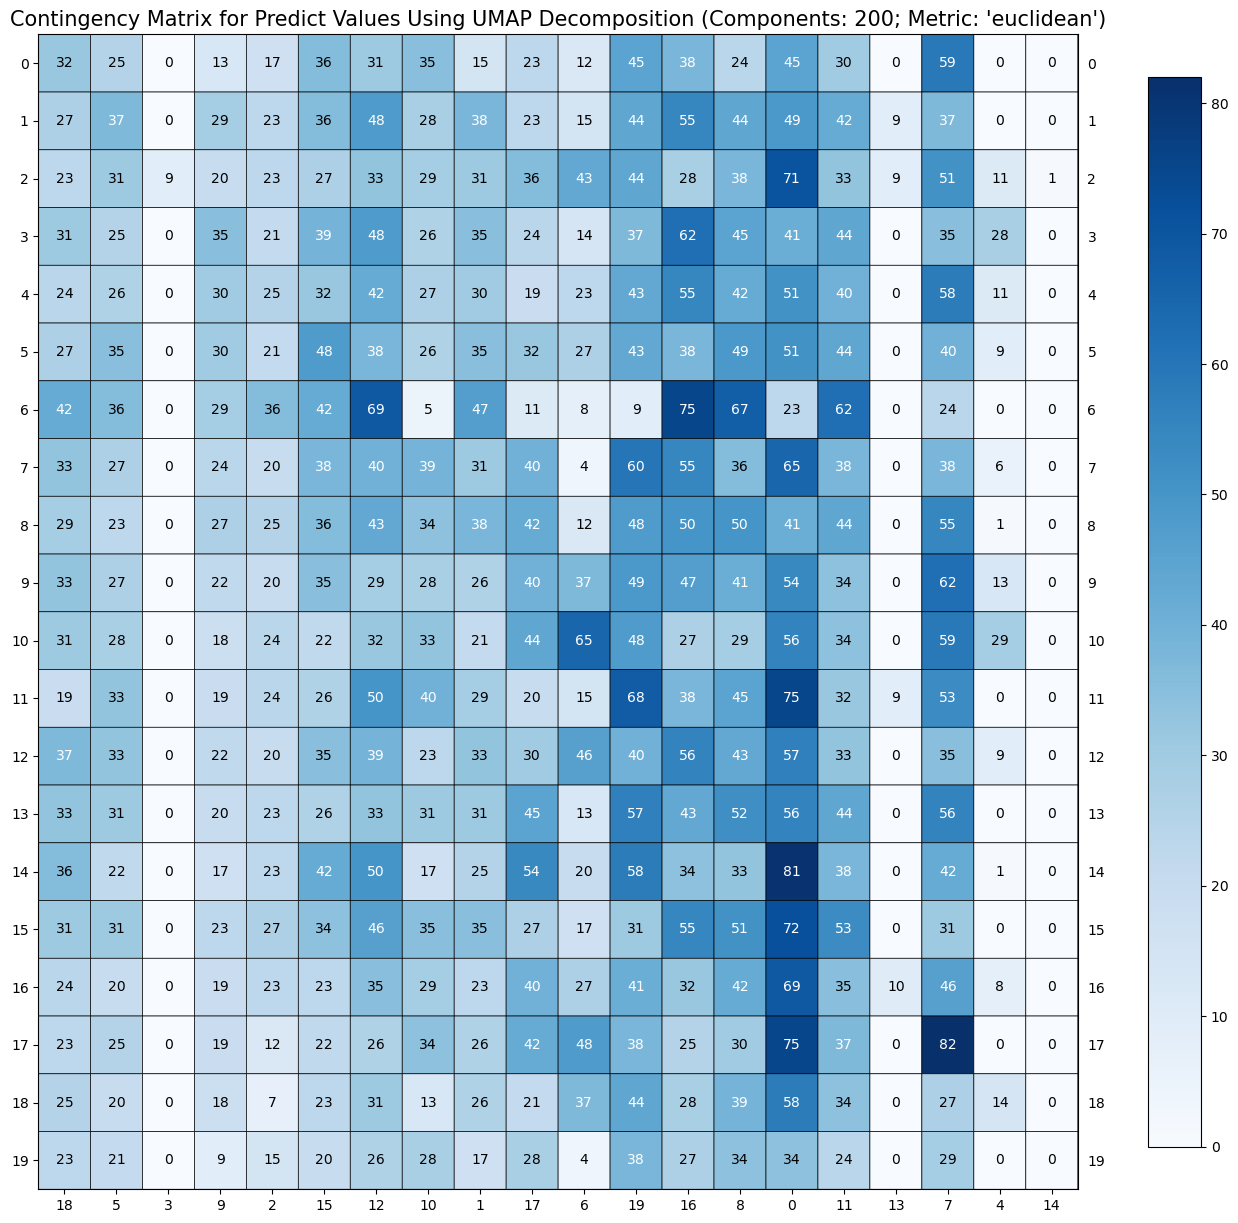

,Components,Metric,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information Score,Rand Score
0,5,cosine,0.565240,0.586000,0.575433,0.421043,0.573093,0.940195
0,5,euclidean,0.018109,0.019288,0.018680,0.002306,0.013198,0.892787
0,20,cosine,0.568820,0.602134,0.585003,0.430864,0.582678,0.938746
0,20,euclidean,0.020725,0.022748,0.021690,0.003372,0.016118,0.887833
0,200,cosine,0.563309,0.582959,0.572966,0.423634,0.570614,0.940740
0,200,euclidean,0.018621,0.019981,0.019277,0.003114,0.013949,0.891425


In [17]:
parameter_grid = {
    'n_components': [5, 20, 200],
    'metric': ['cosine', 'euclidean']
}
eval_df = pd.DataFrame(columns=['Components', 'Metric', 'Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand Index', 'Adjusted Mutual Information Score'])
for n_components in parameter_grid['n_components']:
    for metric in parameter_grid['metric']:
        # UMAP Dimensionality Reduction
        umap_rep = umap.UMAP(n_components=n_components, metric=metric).fit_transform(ng_full_tfidf)

        # K-Means
        kmeans_labels = KMeans(n_clusters=20, random_state=0, max_iter=5000, n_init=50).fit_predict(umap_rep)

        # Contingency Matrix
        cm = confusion_matrix(ng_full_df['class'], kmeans_labels)
        rows, cols = linear_sum_assignment(cm, maximize=True)
        plot_mat(
            cm[rows[:, np.newaxis], cols], 
            xticklabels=cols, 
            yticklabels=rows, 
            size=(15,15),
            title=f'Contingency Matrix for Predict Values Using UMAP Decomposition (Components: {n_components}; Metric: \'{metric}\')'
        )

        # Evalaution Metrics
        eval_metrics = evaluate_cluster_model(ng_full_df['class'], kmeans_labels)
        eval_metrics['Components'] = n_components
        eval_metrics['Metric'] = metric
        eval_df = pd.concat([eval_df, eval_metrics])

eval_df

### Clustering Algorithms That Do Not Explicitly Rely on the Gaussian Distribution Per Cluster

In [20]:
# UMAP + AgglomerativeClustering
agglom_criteria = ['ward', 'complete', 'average', 'single']

umap_rep = umap.UMAP(n_components=20, metric='cosine').fit_transform(ng_full_tfidf)
eval_df = pd.DataFrame(columns=['AgglomerativeClustering Criterion', 'Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand Index', 'Adjusted Mutual Information Score'])

for c in agglom_criteria:
    agg_clust_labels = AgglomerativeClustering(n_clusters=20, linkage=c).fit_predict(umap_rep)

    # Evalaution Metrics
    eval_metrics = evaluate_cluster_model(ng_full_df['class'], agg_clust_labels)
    eval_metrics['AgglomerativeClustering Criterion'] = c
    eval_df = pd.concat([eval_df, eval_metrics])

eval_df

/var/folders/bc/1xf6kfn55rqfytwcbxjxqdr00000gn/T/ipykernel_59665/1041569838.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat([eval_df, eval_metrics])


,AgglomerativeClustering Criterion,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information Score
0,ward,0.548512,0.573457,0.560707,0.391308,0.558275
0,complete,0.528973,0.565395,0.546578,0.374249,0.544037
0,average,0.510684,0.608175,0.555182,0.352201,0.552490
0,single,0.010195,0.310094,0.019742,0.000145,0.013024


In [23]:
# HBDSCAN on UMAP-transformed data
clusters = [20, 100, 200]

umap_rep = umap.UMAP(n_components=20, metric='cosine').fit_transform(ng_full_tfidf)
eval_df = pd.DataFrame(columns=['HBDSCAN Min Cluster Size', 'Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand Index', 'Adjusted Mutual Information Score'])

for c in clusters:
    hdbscan_labels = HDBSCAN(min_cluster_size=c).fit_predict(umap_rep)

    # Evalaution Metrics
    eval_metrics = evaluate_cluster_model(ng_full_df['class'], hdbscan_labels)
    eval_metrics['HBDSCAN Min Cluster Size'] = c
    eval_df = pd.concat([eval_df, eval_metrics])

eval_df

/var/folders/bc/1xf6kfn55rqfytwcbxjxqdr00000gn/T/ipykernel_59665/2996376061.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat([eval_df, eval_metrics])


,HBDSCAN Min Cluster Size,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information Score
0,20,0.000453,0.086175,0.000901,6.844102e-07,0.000246
0,100,0.404183,0.594614,0.481245,1.739615e-01,0.479125
0,200,0.316914,0.606699,0.416346,1.242027e-01,0.414824


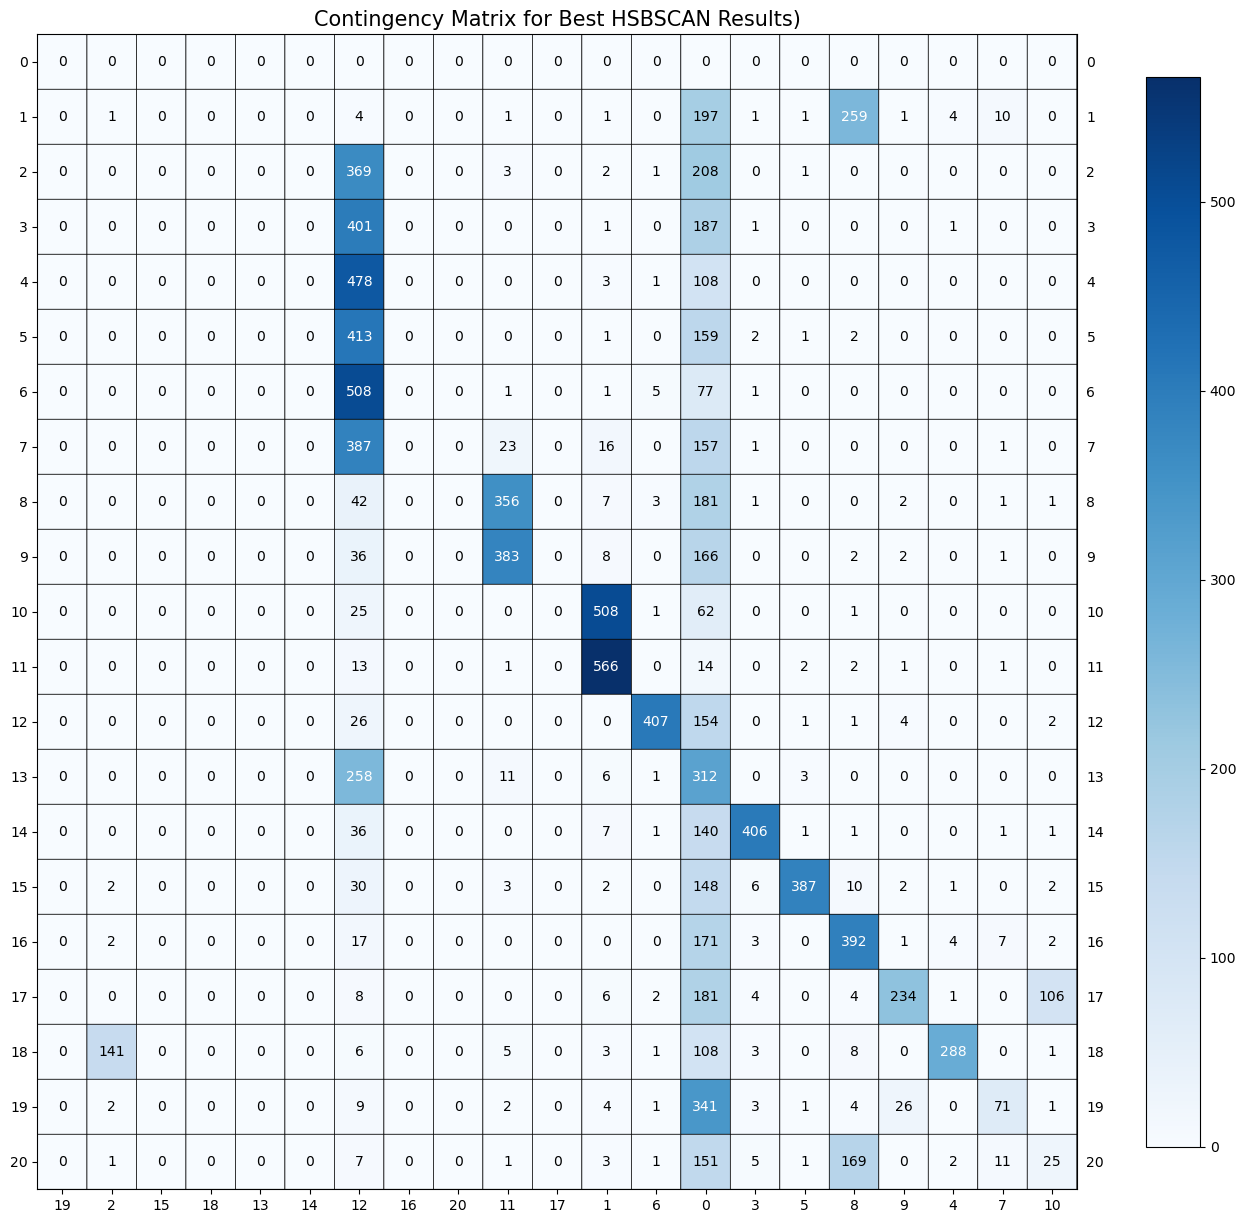

In [24]:
# Best Continengy Matrix from HDBSCAN results above (w/ min_cluster_size=100)
hdbscan_labels = HDBSCAN(min_cluster_size=100).fit_predict(umap_rep)

# Contingency Matrix
cm = confusion_matrix(ng_full_df['class'], hdbscan_labels)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(
    cm[rows[:, np.newaxis], cols], 
    xticklabels=cols, 
    yticklabels=rows, 
    size=(15,15),
    title=f'Contingency Matrix for Best HSBSCAN Results)'
)

In [28]:
pd.Series(hdbscan_labels).value_counts().to_frame().T

,-1,11,0,7,10,2,5,4,3,8,1,9,6
count,3222,3073,1145,855,790,437,425,399,301,273,149,141,104


- The HDBSCAN model produced 12 clusters, 13 if counting the one with a '-1' label.
- A '-1' label indicates a noisy sample.

In [78]:
# Setting up experiment grid
param_options = {
    'models': {
        'dim_reduct_models': [None, TruncatedSVD, NMF, umap.UMAP],
        'clustering_models': [KMeans, AgglomerativeClustering, HDBSCAN]
    },
    'hyperparams': {
        None: {
            'dummy': ['dummy']
        },
        'TruncatedSVD': {
            'n_components': [5, 20, 200]
        },
        'NMF': {
            'n_components': [5, 20, 200]
        },
        'UMAP': {
            'n_components': [5, 20, 200]
        },
        'KMeans': {
            'n_clusters': [10, 20, 50]
        },
        'AgglomerativeClustering': {
            'n_clusters': [20]
        },
        'HDBSCAN': {
            'min_cluster_size': [100, 200]
        }
    }
}

model_opts = param_options['models']
hyperparam_opts = param_options['hyperparams']
eval_df = pd.DataFrame(columns=['DM Model', 'DM Model Params', 'Clustering Model', 'Clustering Model Params', 'Homogeneity', 'Completeness', 'V-measure', 'Adjusted Rand Index', 'Adjusted Mutual Information Score'])


for dm in model_opts['dim_reduct_models']:
    if dm is None:
        dm_name = 'None'
        dm_args = {'None': ['None']}
    else:
        dm_name = type(dm()).__name__
        dm_args = hyperparam_opts[dm_name]
    for dm_arg in (dict(zip(dm_args, x)) for x in itertools.product(*dm_args.values())):
        # Dimensionality Reduction
        if dm is None:
            reduced_tfidf = ng_full_tfidf.toarray() # Have to do this if not reduced...
        else:
            reduced_tfidf = dm(**dm_arg).fit_transform(ng_full_tfidf)
                    
        for cm in model_opts['clustering_models']:
            cm_name = type(cm()).__name__
            cm_args = hyperparam_opts[cm_name]
            for cm_arg in (dict(zip(cm_args, x)) for x in itertools.product(*cm_args.values())):
                print(f'Runnining Combination: \n\r "{dm_name}" Dimensionality Reduction Model w/ Arg "{str(dm_arg)}" \n\r "{cm_name}" Clustering Model w/ Arg "{str(cm_arg)}"')
                
                # Clustering
                cluster_labels = cm(**cm_arg).fit_predict(reduced_tfidf)

                # Evalaution Metrics
                eval_metrics = evaluate_cluster_model(ng_full_df['class'], cluster_labels)
                eval_metrics['DM Model'] = dm_name
                eval_metrics['DM Model Params'] = str(dm_arg)
                eval_metrics['Clustering Model'] = cm_name
                eval_metrics['Clustering Model Params'] = str(cm_arg)
                eval_df = pd.concat([eval_df, eval_metrics])

eval_df

Runnining Combination: 
 "None" Dimensionality Reduction Model w/ Arg "{'None': 'None'}" 
 "KMeans" Clustering Model w/ Arg "{'n_clusters': 10}"


/var/folders/bc/1xf6kfn55rqfytwcbxjxqdr00000gn/T/ipykernel_59665/3228502713.py:66: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  eval_df = pd.concat([eval_df, eval_metrics])


Runnining Combination: 
 "None" Dimensionality Reduction Model w/ Arg "{'None': 'None'}" 
 "KMeans" Clustering Model w/ Arg "{'n_clusters': 20}"
Runnining Combination: 
 "None" Dimensionality Reduction Model w/ Arg "{'None': 'None'}" 
 "KMeans" Clustering Model w/ Arg "{'n_clusters': 50}"
Runnining Combination: 
 "None" Dimensionality Reduction Model w/ Arg "{'None': 'None'}" 
 "AgglomerativeClustering" Clustering Model w/ Arg "{'n_clusters': 20}"
Runnining Combination: 
 "None" Dimensionality Reduction Model w/ Arg "{'None': 'None'}" 
 "HDBSCAN" Clustering Model w/ Arg "{'min_cluster_size': 100}"
Runnining Combination: 
 "None" Dimensionality Reduction Model w/ Arg "{'None': 'None'}" 
 "HDBSCAN" Clustering Model w/ Arg "{'min_cluster_size': 200}"


KeyboardInterrupt: 

In [ ]:
eval_df.to_parquet('./dim_reduction_cluster_results.parquet')

In [79]:
eval_df

,DM Model,DM Model Params,Clustering Model,Clustering Model Params,Homogeneity,Completeness,V-measure,Adjusted Rand Index,Adjusted Mutual Information Score
0,None,{'None': 'None'},KMeans,{'n_clusters': 10},0.311309,0.505024,0.385182,0.104301,0.383240
0,None,{'None': 'None'},KMeans,{'n_clusters': 20},0.357614,0.436636,0.393194,0.104761,0.389558
0,None,{'None': 'None'},KMeans,{'n_clusters': 50},0.435934,0.377360,0.404538,0.123068,0.396520
0,None,{'None': 'None'},AgglomerativeClustering,{'n_clusters': 20},0.333834,0.477584,0.392975,0.125999,0.388957
0,None,{'None': 'None'},HDBSCAN,{'min_cluster_size': 100},0.000000,1.000000,0.000000,0.000000,0.000000
